# Generate test data

In [296]:
from lmfit import Parameters, report_fit, minimize
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


%pwd
from EnzymePynetics.core.measurement import Measurement
from EnzymePynetics.core.enzymekinetics import EnzymeKinetics
from EnzymePynetics.core.species import Species
from EnzymePynetics.core.series import Series


## Irreversible MM

In [297]:
# Parameters of test reaction system
KM = 4
KCAT = 12

init_sub = [0.5, 2, 8, 15, 30]
enzyme = 0.01

In [298]:
# Parameters for data generation
params = Parameters()
params.add("k_cat", value=KCAT, min=0.01*KCAT, max=100*KCAT)
params.add("K_m", value=KM, min=0.01*KM, max=100*KM)

In [299]:
# Kinetic model
def menten_irrev(w0: tuple, t, params):
    cS, cE, cP, cI = w0

    k_cat = params['k_cat'].value
    K_m = params['K_m'].value

    dc_S = -k_cat * cE * cS / (K_m+cS)
    dc_E = 0
    dc_P = -dc_S
    dc_I = 0

    return (dc_S, dc_E, dc_P, dc_I)

# Integrator for MM rate equation
def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(menten_irrev, w0, t, args=(params,))
    return w

In [300]:
# Generate time-course data
time = np.arange(21)

substrate = np.empty((len(init_sub), len(time)))
for i, conc in enumerate(init_sub):
    substrate[i] = g(t=time, w0=(conc, enzyme, 0, 0), params=params).T[0]

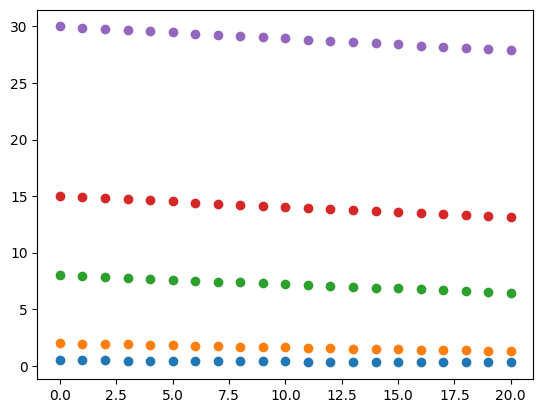

In [301]:
for conc in substrate:
    plt.scatter(time, conc)
plt.show()    

In [302]:
# Write data to json
measurements=[]

for init_substrate, sub in zip(init_sub, substrate):

    species = Species(name="test substrate",
                      reactant_type="substrate",
                      conc_unit="mmole / l",
                      initial_conc=init_substrate,
                      data=[Series(values=sub.tolist())])


    measurements.append(Measurement(time_unit="min", 
                                    time=time.tolist(),
                                    enzyme_conc=enzyme,
                                    temperature=37,
                                    temperature_unit="C",
                                    pH=7,
                                    species=[species]))
    
enzyme_kinetics = EnzymeKinetics(title="test irreversible MM",
                                 measurements=measurements)

with open("irrev_MM.json", "w") as f:
    f.write(enzyme_kinetics.json())

## Irreversible MM - integrated form

In [303]:
substrate.shape

(5, 21)

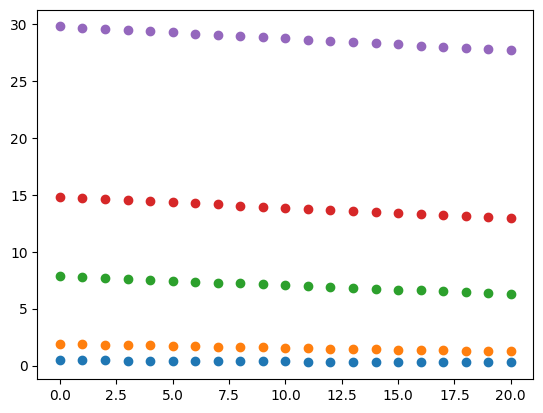

In [304]:
time = np.arange(23)

substrate = np.empty((len(init_sub), len(time)))
for i, conc in enumerate(init_sub):
    substrate[i] = g(t=time, w0=(conc, enzyme, 0, 0), params=params).T[0]

substrate = substrate[:,2:]
time = time[:-2]
for conc in substrate:
    plt.scatter(time, conc)
plt.show()  

In [305]:
measurements=[]

for init_substrate, sub in zip(init_sub, substrate):

    species = Species(name="test substrate",
                      reactant_type="substrate",
                      conc_unit="mmole / l",
                      initial_conc=init_substrate,
                      data=[Series(values=sub.tolist())])


    measurements.append(Measurement(time_unit="min", 
                                    time=time.tolist(),
                                    enzyme_conc=enzyme,
                                    temperature=37,
                                    temperature_unit="C",
                                    pH=7,
                                    species=[species]))
    
enzyme_kinetics = EnzymeKinetics(title="test irreversible MM",
                                 measurements=measurements)

with open("irrev_MM_with_2min_delay.json", "w") as f:
    f.write(enzyme_kinetics.json())

[ 0.26014118  0.08667707  0.72170611  0.05659842  0.73830837  1.05355014
  1.68030537  0.76909493  1.71641344  1.60567945  2.14710609  2.29871153
  2.41806595  3.01687871  3.01948499  3.12542233  3.02571726  3.6223418
  4.16219481  4.33864585  4.45195189  5.04449088  4.77637707  5.35031457
  5.38020171  6.27865982  5.83781325  6.16641856  6.09050207  6.58088285
  7.19262603  7.15424597  7.27915315  7.52323985  8.22619613  8.68660715
  8.92338255  9.12478259  9.90022874  9.76733329 10.247028   11.15540394
 11.38612339 11.37105032 12.16912288 12.46331515 13.48441422 13.3766771
 14.47358399 15.26215677]


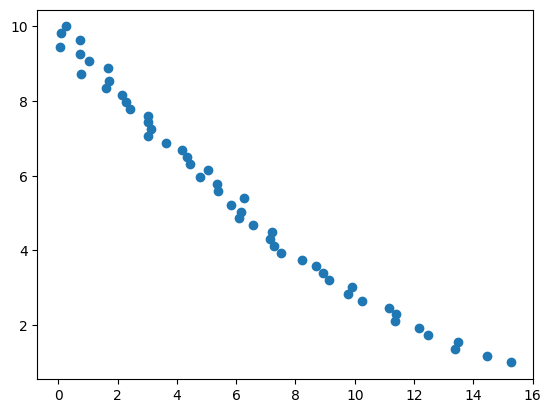

In [306]:
concentration = np.linspace(10,1)
s0 = 10
km = 5
kcat = 34
t0 = 0
e = 0.04

def irrev_mm(st: float):
    return -1/(kcat*e)*(km* np.log(st/s0) + (st-s0)) + t0

def iMM(s):
    pass 

time = [irrev_mm(x) for x in concentration]
time = np.random.normal(0,0.3, size=concentration.size) +time


print(time)


plt.scatter(time, concentration)

In [307]:
# params
params = Parameters()
params.add("k_cat", value=1, min=0.01*KCAT, max=100*KCAT)
params.add("K_m", value=1, min=0.01*KM, max=100*KM)
params.add("t_0", value=0, min=-10, max=10)

params.valuesdict()["K_m"]

1

In [308]:
def integrated_MM(k_cat: float,
                  K_m: float,
                  enzyme: float,
                  substrate: float,
                  init_substrate: float,
                  t_0: float,
                  k_inactivation: float = None,
                  enzyme_inactivation: bool = False,
                  ) -> float:
    
    if enzyme_inactivation:
        enzyme = np.exp(-k_inactivation * enzyme)
    
    return -1/(k_cat*enzyme)*(K_m* np.log(substrate/init_substrate) + (substrate-init_substrate)) + t_0

def residuals(params: Parameters, time, substrate, s0, enzyme):
    param_values = params.valuesdict()
    km = param_values["K_m"]
    t0 = param_values["t_0"]
    kcat = param_values["k_cat"]

    residuals = substrate * 0.0
    for init_S, s in zip(init_sub, substrate):
    
        model = integrated_MM(k_cat=kcat,
                              K_m=km,
                              enzyme=enzyme,
                              substrate=s,
                              init_substrate=init_S,
                              t_0=t0)

        residuals = model - time
    return residuals.flatten()



result = minimize(residuals, params, args=(time, substrate, init_sub, enzyme))
report_fit(result)

ValueError: operands could not be broadcast together with shapes (21,) (50,) 

In [ ]:
for s in substrate:
    print(s)
    print("bobo")

[0.5        0.48682374 0.47395794 0.46139699 0.44913533 0.43716741
 0.42548774 0.41409084 0.40297127 0.39212363 0.38154257 0.37122279
 0.36115901 0.35134603 0.34177869 0.33245188 0.32336055 0.31449971
 0.30586443 0.29744984 0.28925113]
bobo
[2.         1.96026665 1.92106655 1.88239947 1.84426507 1.80666284
 1.76959214 1.73305212 1.69704186 1.66156023 1.62660597 1.59217768
 1.55827379 1.52489258 1.49203218 1.45969057 1.42786557 1.39655487
 1.365756   1.33546633 1.3056831 ]
bobo
[8.         7.92013379 7.84053689 7.76121208 7.68216205 7.60338957
 7.52489743 7.44668844 7.36876543 7.29113128 7.21378888 7.13674115
 7.05999103 6.98354149 6.90739553 6.83155618 6.75602647 6.68080949
 6.60590833 6.53132611 6.45706599]
bobo
[15.         14.90532634 14.8107797  14.71636125 14.6220721  14.52791336
 14.4338862  14.33999176 14.24623121 14.15260576 14.05911658 13.96576491
 13.87255196 13.77947897 13.68654721 13.59375794 13.50111245 13.40861204
 13.31625801 13.22405171 13.13199448]
bobo
[30.         29

In [ ]:
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [ ]:
#for concentration, s0 in zip(substrate, init_sub):
result = minimize(residuals, params, args=(time, substrate[-1], init_sub[-1], enzyme))
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 21
    # variables        = 3
    chi-square         = 3.9334e-14
    reduced chi-square = 2.1852e-15
    Akaike info crit   = -706.135183
    Bayesian info crit = -703.001616
[[Variables]]
    k_cat:  12.0000035 +/- 2.3272e-06 (0.00%) (init = 1)
    K_m:    4.00000944 +/- 6.3464e-06 (0.00%) (init = 1)
    t_0:    1.99999996 +/- 3.9959e-08 (0.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_m) = 1.000
    C(k_cat, t_0) = -0.828
    C(K_m, t_0)   = -0.824


## Run old solver

In [ ]:
def g(time: np.ndarray, w0: tuple, params):
            '''
            Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
            '''
            w = odeint(kineticmodel.model, w0, time, args=(params, self.enzyme_inactivation,))
            return w

def residual(params, time: np.ndarray, substrate: np.ndarray):
    """
    Calculated the distance between measured and modeled data.
    """
    residuals = 0.0 * substrate
    for i, measurement in enumerate(substrate):

    # Calculate residual for each measurement
        cS, cE, cP, cI, = kineticmodel.w0.values()
        w0 = (cS[i], cE[i, 0], 0, cI[i, 0]) #cP[i, 0]
        # TODO check data in model and measurement 

        model = g(time, w0, params)  # solve the ODE with sfb.

        # get modeled substrate
        model = model[:, 0]

        # compute distance to measured data
        residuals[i] = measurement-model

    self.residuals=residuals
    return residuals.flatten()

minimize(residual, params, args=(time, substrate), method='leastsq', nan_policy='omit')



NameError: name 'kineticmodel' is not defined